Importamos las librerias necesarias para el desarrollo del proyecto

In [24]:
import os
from dotenv import load_dotenv
from PyPDF2 import PdfReader
from langchain.document_loaders import TextLoader
from langchain.chains import RetrievalQA
from langchain.embeddings import OpenAIEmbeddings
from langchain.vectorstores import FAISS
from langchain_community.chat_models import ChatOpenAI
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import matplotlib.pyplot as plt


Cargamos la API de OpenAI de manera confidencial 

In [25]:
load_dotenv()
api_key = os.getenv('OPENAI_API_KEY')

if api_key:
    print("API Key cargada correctamente.")
else:
    raise ValueError("No se ha encontrado la API Key en el archivo .env")

# Configurar la clave de API de OpenAI
os.environ["OPENAI_API_KEY"] = api_key

API Key cargada correctamente.


Cargamos el documento sobre el ue vamos a trabajar y posteriormente mostramos el contenido

In [26]:
def extract_text_from_pdf(pdf_path):
    try:
        reader = PdfReader(pdf_path)
        text = ""
        for page in reader.pages:
            page_text = page.extract_text()
            if page_text:
                text += page_text
        if not text:
            raise ValueError("El texto extraído del PDF está vacío.")
        return text
    except Exception as e:
        print(f"Error al extraer texto del PDF: {e}")
        return ""


# Ruta al documento PDF
pdf_path = "C:\\Users\\gonzalo.arguedas\\Project\\TFG\\Langchain_evaluation\\How to Become a Straight-A Student.pdf"

# Extraer texto del documento PDF
document_text = extract_text_from_pdf(pdf_path)

# Guardar el texto extraído en un archivo temporal
with open("temp_document.txt", "w", encoding="utf-8") as f:
    f.write(document_text)

# Cargar el texto del documento
document_loader = TextLoader("temp_document.txt")
documents = document_loader.load()

# Mostrar el contenido del documento (primeros 500 caracteres)
print("Contenido del documento:")
print(documents[0].page_content[:500])

Contenido del documento:
How to Become a Straight-A Student 
Summary
By  Cal Newport
When you close your eyes and imagine a straight-A student, you
probably picture someone who studies for a long time and has very little
social life, or someone who is annoyingly and naturally gifted.
How to Become a Straight-A Student is a fun, pragmatic look at succeeding,
while also enjoying college life.You don't need to grind hard or be
naturally talented to excel, and Newport's research shows that straight-A
students have numerous 


A continuación hemos realizado lo siguiente:

- Crear embeddings con OpenAI: Se generan representaciones vectoriales de los documentos utilizando la clase OpenAIEmbeddings, lo que permite convertir texto en vectores numéricos en un espacio de alta dimensión.

- Indexar los documentos utilizando FAISS: Se utiliza la biblioteca FAISS para indexar estos vectores en un almacén de vectores, lo que facilita búsquedas rápidas y eficientes basadas en similitud.

- Configurar el recuperador: Se configura un recuperador a partir del almacén de vectores, permitiendo recuperar documentos relevantes basados en la similitud de sus embeddings con las consultas realizadas.

In [27]:
embeddings = OpenAIEmbeddings()

vector_store = FAISS.from_documents(documents, embeddings)

retriever = vector_store.as_retriever()

Se crea un modelo de lenguaje utilizando ChatOpenAI con el modelo "gpt-3.5-turbo" y la clave de API proporcionada. A continuación, se configura una cadena de preguntas y respuestas (qa_chain) con la clase RetrievalQA, utilizando el modelo de lenguaje y un recuperador. La cadena de tipo "stuff" gestiona la interacción entre el modelo y el recuperador para responder preguntas basadas en el contenido de los documentos indexados.

In [30]:
# Crear el modelo de lenguaje OpenAI
llm = ChatOpenAI(api_key=api_key, model_name="gpt-4-turbo")

# Configurar la cadena de preguntas y respuestas
qa_chain = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",  # Utilizando el tipo de cadena 'stuff'
    retriever=retriever
)

A continuación se realizan una serie de preguntas para el documento el cual se esta trabjando

In [31]:
# Ejemplos de preguntas
preguntas = [
    "¿Cuál es el tema principal del documento?",
    "¿Qué datos específicos se mencionan en el segundo párrafo?",
    "Proporcione un resumen del documento.",
    "¿Hay alguna información contradictoria en el texto?",
    "¿Qué conclusiones se pueden extraer del documento?"
]

# Realizar preguntas y obtener respuestas
for pregunta in preguntas:
    respuesta = qa_chain.run({"query": pregunta})
    print(f"Pregunta: {pregunta}")
    print(f"Respuesta: {respuesta}\n")


Pregunta: ¿Cuál es el tema principal del documento?
Respuesta: El tema principal del documento es cómo convertirse en un estudiante de calificaciones sobresalientes en la universidad empleando estrategias efectivas y eficientes de estudio y aprendizaje, sin necesidad de sacrificar la vida social o sufrir estrés excesivo. El libro "How to Become a Straight-A Student" de Cal Newport propone métodos para trabajar de manera más inteligente, no más dura, enfocándose en la intensidad y la calidad del estudio en lugar de la cantidad de tiempo dedicado a estudiar.

Pregunta: ¿Qué datos específicos se mencionan en el segundo párrafo?
Respuesta: En el segundo párrafo del resumen del libro "How to Become a Straight-A Student" de Cal Newport, se menciona que Newport estudió en Dartmouth y trabajó arduamente durante su primer año, pero sin obtener los resultados deseados. Esto lo llevó a reevaluar sus métodos de aprendizaje y adoptar nuevas estrategias y técnicas para optimizar su estudio. También 

Este documento describe el proceso de evaluación de la precisión de las respuestas generadas por un modelo de lenguaje utilizando similitud coseno. El objetivo es determinar si las respuestas proporcionadas por el modelo son precisas en relación con el contenido del documento.

**Proceso para Evaluar la Precisión Usando Similitud Coseno**

1. **Generación de Embeddings**:
   - Convertir tanto la respuesta generada por el modelo como el texto relevante del documento en vectores numéricos (embeddings).
   - Los embeddings son representaciones en un espacio vectorial de los textos, donde textos similares están más cercanos entre sí.

2. **Cálculo de la Similitud Coseno**:
   - La similitud coseno se utiliza para medir la similitud entre dos vectores.
   - Fórmula de la similitud coseno:
     $$
     \text{similitud coseno} = \frac{\mathbf{A} \cdot \mathbf{B}}{\|\mathbf{A}\| \|\mathbf{B}\|}
     $$
     donde:
     - **A** y **B** son los vectores de embedding de la respuesta y el texto del documento, respectivamente.
     - **A · B** es el producto punto de los dos vectores.
     - **||A|| ||B||** son las magnitudes (normas) de los vectores.

3. **Determinación de Precisión**:
   - Se define un umbral de similitud.
   - Si la similitud coseno es mayor que este umbral, la respuesta se considera precisa; de lo contrario, se considera una alucinación.


In [32]:
# Función para verificar la precisión de las respuestas
def verificar_respuesta(pregunta, respuesta, contexto, embeddings, umbral_similitud=0.8):
    try:
        respuesta_embedding = embeddings.embed_query(respuesta)
        contexto_embedding = embeddings.embed_query(contexto)
        similitud = cosine_similarity([respuesta_embedding], [contexto_embedding])[0][0]
        if similitud > umbral_similitud:
            return "Precisa", similitud
        else:
            return "Alucinación", similitud
    except Exception as e:
        print(f"Error al verificar la respuesta: {e}")
        return "Error", 0.0

Verficamos las respuestas

In [33]:
resultados = []

for pregunta in preguntas:
    respuesta = qa_chain.run({"query": pregunta})
    precision, similitud = verificar_respuesta(pregunta, respuesta, documents[0].page_content, embeddings)
    print(f"Pregunta: {pregunta}")
    print(f"Respuesta: {respuesta}")
    print(f"Precisión: {precision}")
    print(f"Similitud: {similitud}\n")
    resultados.append((pregunta, respuesta, precision, similitud))

Pregunta: ¿Cuál es el tema principal del documento?
Respuesta: El tema principal del documento es cómo convertirse en un estudiante de calificaciones sobresalientes (Straight-A student) utilizando técnicas y estrategias efectivas para estudiar y aprender de manera más eficiente, sin necesidad de sacrificar la vida social o someterse a estrés excesivo. Se enfatiza en trabajar de manera más inteligente, no más dura, mediante la aplicación de un enfoque de trabajo real e intenso, conocido como "deep work".
Precisión: Precisa
Similitud: 0.8696368727228669

Pregunta: ¿Qué datos específicos se mencionan en el segundo párrafo?
Respuesta: En el segundo párrafo del resumen del libro "How to Become a Straight-A Student" de Cal Newport, se menciona que Newport estudió en Dartmouth y trabajó arduamente en su primer año, pero no logró los resultados deseados. Esto lo llevó a reevaluar sus métodos de aprendizaje y adoptar nuevas estrategias y trucos para optimizar su estudio. Además, se menciona que

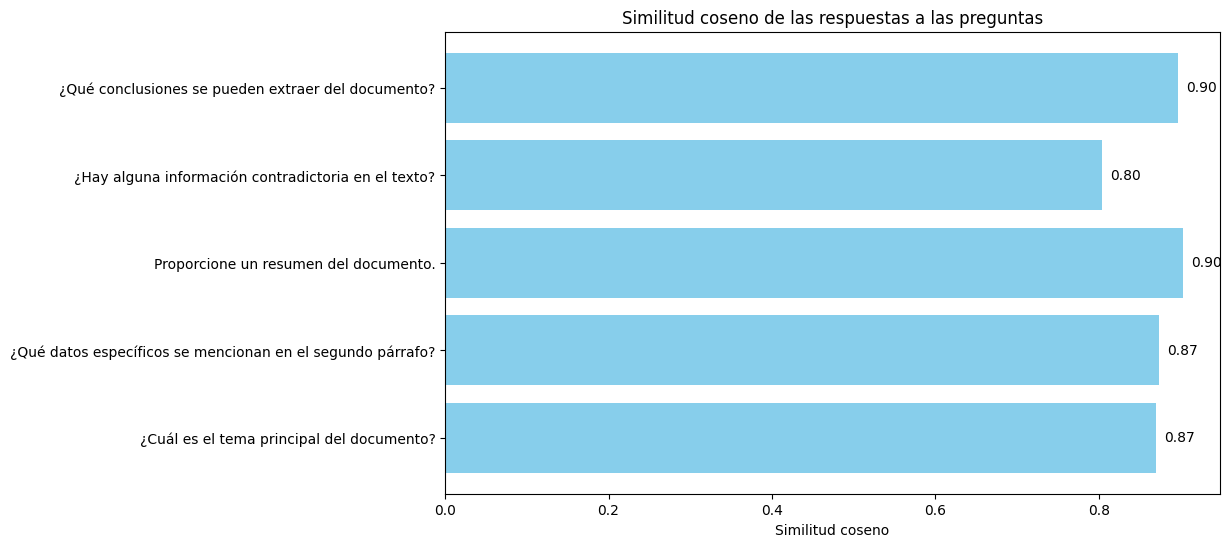

In [35]:
preguntas = [r[0] for r in resultados]
similitudes = [r[3] for r in resultados]

plt.figure(figsize=(10, 6))
bars = plt.barh(preguntas, similitudes, color='skyblue')
plt.xlabel('Similitud coseno')
plt.title('Similitud coseno de las respuestas a las preguntas')

# Añadir etiquetas con los valores obtenidos para cada barra
for bar, similitud in zip(bars, similitudes):
    plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height() / 2, f'{similitud:.2f}', 
             va='center', ha='left', fontsize=10, color='black')

plt.show()
